In [1]:
import pandas as pd

In [2]:
file_path = 'demo1_historic.csv'
df_student_historic_raw_data = pd.read_csv(file_path)

In [3]:
df_student_historic_raw_data.shape

(1000, 10)

In [4]:
df_student_historic_raw_data.head()

,ID,Age,Is_Married,Has_Children,Children_Count,Home_Distance,Drinks_Tea,Lectures_Missed,Average_Assignments_Score,Exam_Result
0,S1,41,1,1,3,23,0,1,41,1
1,S2,37,0,0,0,5,1,8,75,1
2,S3,49,0,0,0,44,1,9,52,1
3,S4,24,0,0,0,40,1,1,54,1
4,S5,48,1,1,3,36,0,2,32,1


In [5]:
df_student_historic_raw_data.query('Has_Children==0 and Children_Count>0')

,ID,Age,Is_Married,Has_Children,Children_Count,Home_Distance,Drinks_Tea,Lectures_Missed,Average_Assignments_Score,Exam_Result


In [6]:
df_student_historic_raw_data.query('Has_Children==1 and Children_Count==0')

,ID,Age,Is_Married,Has_Children,Children_Count,Home_Distance,Drinks_Tea,Lectures_Missed,Average_Assignments_Score,Exam_Result


### Feature selection and data splitting

In [7]:
features = df_student_historic_raw_data.drop(['ID', 'Exam_Result'], axis=1)
features.shape

(1000, 8)

In [8]:
labels = df_student_historic_raw_data['Exam_Result']
labels.shape

(1000,)

In [9]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(features, labels, random_state=0)

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(750, 8) (750,)
(250, 8) (250,)


In [10]:
type(y_test)

pandas.core.series.Series

### Trying RFC for classification task (classifying result as fail or pass)

In [11]:
from sklearn.ensemble import RandomForestClassifier as RFC

rfc_model_1 = RFC(random_state=0)

rfc_model_1.fit(x_train, y_train)

/home/ngarg/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

### Evaluating the trained RFC model using the test set

In [12]:
y_hat = rfc_model_1.predict(x_test)

In [13]:
type(y_hat)

numpy.ndarray

In [14]:
y_actual = pd.Series(y_test.values, name='Actual')
y_predicted = pd.Series(y_hat, name=' Predicted')
cm = pd.crosstab(y_actual, y_predicted)
cm

Predicted,0,1
Actual,,
0,45,52
1,34,119


In [15]:
from sklearn.metrics import accuracy_score

print('Accuracy Score: ', accuracy_score(y_test, y_hat))

Accuracy Score:  0.656


### Tuning the model using GridSearchCV

In [16]:
from sklearn.model_selection import GridSearchCV

hyperparameters_grid = {
    'n_estimators': [10, 20, 40, 80, 100], 
    'max_features': [None, 'sqrt', 'log2']
}

gscv_rfc = GridSearchCV(estimator=rfc_model_1, param_grid=hyperparameters_grid, cv=4)

gscv_rfc.fit(x_train, y_train)

print(gscv_rfc.best_params_)

{'max_features': None, 'n_estimators': 80}


/home/ngarg/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [17]:
y_hat_2 = gscv_rfc.predict(x_test)

y_actual_2 = pd.Series(y_test.values, name='Actual')
y_predicted_2 = pd.Series(y_hat_2, name=' Predicted')
cm_2 = pd.crosstab(y_actual_2, y_predicted_2)
cm_2

Predicted,0,1
Actual,,
0,43,54
1,33,120


In [18]:
print('Accuracy Score: ', accuracy_score(y_test, y_hat_2))

Accuracy Score:  0.652


In [19]:
rfc_model_2 = RFC(random_state=0, max_features=None, n_estimators=80)
rfc_model_2.fit(x_train, y_train)
y_hat_3 = rfc_model_2.predict(x_test)
print('Accuracy Score: ', accuracy_score(y_test, y_hat_3))

Accuracy Score:  0.652


In [20]:
hyperparameters_grid_2 = {
    'n_estimators': [50, 100, 200, 500, 700, 1000], 
    'max_features': [None, 'sqrt', 'log2']
}

gscv_rfc_2 = GridSearchCV(estimator=RFC(random_state=0), param_grid=hyperparameters_grid_2, cv=4)

gscv_rfc_2.fit(x_train, y_train)

print(gscv_rfc_2.best_params_)

/home/ngarg/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'max_features': 'sqrt', 'n_estimators': 500}


In [21]:
y_hat_4 = gscv_rfc_2.predict(x_test)
print('Accuracy Score: ', accuracy_score(y_test, y_hat_4))

Accuracy Score:  0.688


### Feature Importances as identified by RFC

In [22]:
rfc_model_3 = RFC(random_state=0, max_features='sqrt', n_estimators=500)
rfc_model_3.fit(x_train, y_train)
y_hat_5 = rfc_model_3.predict(x_test)
print('Accuracy Score: ', accuracy_score(y_test, y_hat_5))
print(list(rfc_model_3.feature_importances_))

Accuracy Score:  0.688
[0.20946786284140986, 0.02568952853074575, 0.01342173191985556, 0.04358354783235882, 0.2227756820730465, 0.03197102042325868, 0.18305681692847972, 0.27003380945084515]


In [23]:
x_test.head(1)

,Age,Is_Married,Has_Children,Children_Count,Home_Distance,Drinks_Tea,Lectures_Missed,Average_Assignments_Score
993,26,0,0,0,15,0,8,51


### More models for experiments: using different feature combinations

In [24]:
features_2 = df_student_historic_raw_data.drop(['ID', 'Is_Married', 'Has_Children', 'Children_Count', 'Drinks_Tea', 'Exam_Result'], axis=1)
features_2.shape

(1000, 4)

In [25]:
x_train_2, x_test_2, y_train, y_test = train_test_split(features_2, labels, random_state=0)

print(x_train_2.shape, y_train.shape)
print(x_test_2.shape, y_test.shape)

(750, 4) (750,)
(250, 4) (250,)


In [26]:
rfc_model_4 = RFC(random_state=0, max_features='sqrt', n_estimators=500)
rfc_model_4.fit(x_train_2, y_train)
y_hat_6 = rfc_model_4.predict(x_test_2)
print('Accuracy Score: ', accuracy_score(y_test, y_hat_6))

Accuracy Score:  0.68


In [27]:
features_3 = df_student_historic_raw_data[['Age', 'Children_Count', 'Home_Distance', 'Lectures_Missed', 'Average_Assignments_Score']]
x_train_3, x_test_3, y_train, y_test = train_test_split(features_3, labels, random_state=0)
rfc_model_5 = RFC(random_state=0, max_features='sqrt', n_estimators=500)
rfc_model_5.fit(x_train_3, y_train)
y_hat_7 = rfc_model_5.predict(x_test_3)
print('Accuracy Score: ', accuracy_score(y_test, y_hat_7))

Accuracy Score:  0.692


### Checking variable correlations using heatmap (part of EDA)

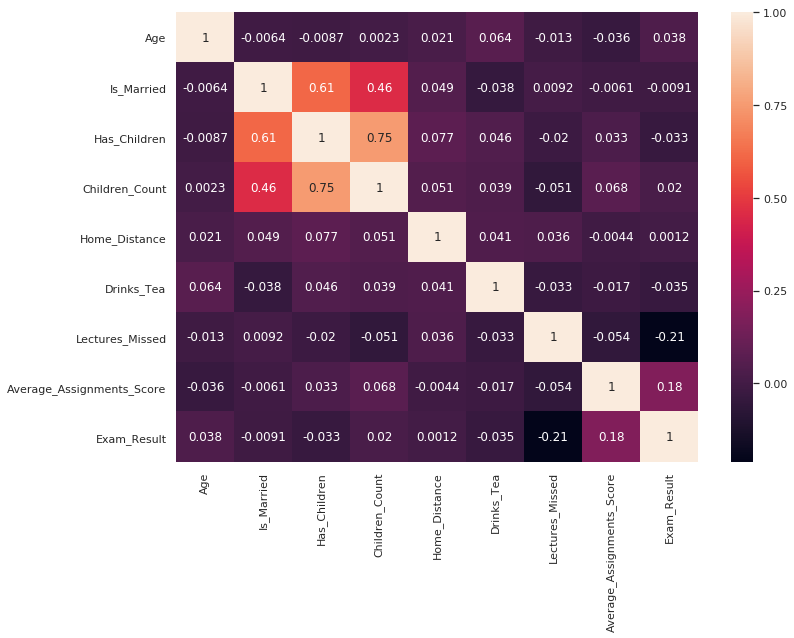

In [28]:
import seaborn as sns
%matplotlib inline
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.heatmap(df_student_historic_raw_data.drop(['ID'], axis=1).corr(), annot=True)

### A couple more models according to correlation results

In [30]:
features_4 = df_student_historic_raw_data[['Age', 'Children_Count', 'Drinks_Tea', 'Lectures_Missed', 'Average_Assignments_Score']]
x_train_4, x_test_4, y_train, y_test = train_test_split(features_4, labels, random_state=0)
rfc_model_6 = RFC(random_state=0, max_features='sqrt', n_estimators=500)
rfc_model_6.fit(x_train_4, y_train)
y_hat_8 = rfc_model_6.predict(x_test_4)
print('Accuracy Score: ', accuracy_score(y_test, y_hat_8))

Accuracy Score:  0.676


In [31]:
features_5 = df_student_historic_raw_data[['Lectures_Missed', 'Average_Assignments_Score']]
x_train_5, x_test_5, y_train, y_test = train_test_split(features_5, labels, random_state=0)
rfc_model_7 = RFC(random_state=0, max_features='sqrt', n_estimators=500)
rfc_model_7.fit(x_train_5, y_train)
y_hat_9 = rfc_model_7.predict(x_test_5)
print('Accuracy Score: ', accuracy_score(y_test, y_hat_9))

Accuracy Score:  0.604


### Building a model comparision table

In [32]:
model = [rfc_model_1, rfc_model_2, rfc_model_3, rfc_model_4, rfc_model_5, rfc_model_6, rfc_model_7]
model_features = [list(x_train.columns), list(x_train.columns), list(x_train.columns), list(x_train_2.columns), list(x_train_3.columns), list(x_train_4.columns), list(x_train_5.columns)]
model_test_set = [x_test, x_test, x_test, x_test_2, x_test_3, x_test_4, x_test_5]
model_hyperparameter_max_features = ['auto', 'None', 'sqrt', 'sqrt', 'sqrt', 'sqrt', 'sqrt']
model_hyperparameter_n_estimators = [10, 80, 500, 500, 500, 500, 500]
model_name = []
model_feature_count = []
model_accuracy = []

# populate the empty lists
for i in range(7):
    model_name.append('rfc_model_'+str(i+1))
    model_feature_count.append(model[i].n_features_)
    model_accuracy.append(accuracy_score(y_test, model[i].predict(model_test_set[i])))

# create a dataframe from the lists
df_model_evaluation = pd.DataFrame({'name': model_name, 
                                    'feature_count': model_feature_count,
                                    'accuracy': model_accuracy, 
                                    'max_features': model_hyperparameter_max_features, 
                                    'n_estimators': model_hyperparameter_n_estimators})

# feature list padding for models that used less than 8 features
for i in range(7):
    feature_count = len(model_features[i])
    if feature_count < 8:
        for j in range(feature_count, 8):
            model_features[i].append('')

# add columns to the dataframe for each feature 
for i in range(8):
    df_model_evaluation['feature'+str(i+1)] = [x[i] for x in model_features]
df_model_evaluation

,name,feature_count,accuracy,max_features,n_estimators,feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature8
0,rfc_model_1,8,0.656,auto,10,Age,Is_Married,Has_Children,Children_Count,Home_Distance,Drinks_Tea,Lectures_Missed,Average_Assignments_Score
1,rfc_model_2,8,0.652,None,80,Age,Is_Married,Has_Children,Children_Count,Home_Distance,Drinks_Tea,Lectures_Missed,Average_Assignments_Score
2,rfc_model_3,8,0.688,sqrt,500,Age,Is_Married,Has_Children,Children_Count,Home_Distance,Drinks_Tea,Lectures_Missed,Average_Assignments_Score
3,rfc_model_4,4,0.680,sqrt,500,Age,Home_Distance,Lectures_Missed,Average_Assignments_Score,,,,
4,rfc_model_5,5,0.692,sqrt,500,Age,Children_Count,Home_Distance,Lectures_Missed,Average_Assignments_Score,,,
5,rfc_model_6,5,0.676,sqrt,500,Age,Children_Count,Drinks_Tea,Lectures_Missed,Average_Assignments_Score,,,
6,rfc_model_7,2,0.604,sqrt,500,Lectures_Missed,Average_Assignments_Score,,,,,,
